In [1]:
import urllib2
from bs4 import BeautifulSoup
from collections import defaultdict
import pickle
import bs4
import numpy as np
import matplotlib.pyplot as plt

In [2]:
url = 'https://www.beeradvocate.com/lists/popular/'

In [3]:
req = urllib2.Request(url, headers={'User-Agent' : "Magic Browser"}) 
con = urllib2.urlopen( req )

Beer Advocate has a list of the 250 most rated beers.  This is what I would like to work off of.  It would be great to capture the html code for all of the pages corresponding to this beer and store them somewhere so I don't need to access the website everytime.

In [4]:
soup = BeautifulSoup(con, 'lxml')

In [5]:
print soup.prettify()

<!DOCTYPE html>
<html class="Public NoJs uix_javascriptNeedsInit LoggedOut Sidebar Responsive pageIsLtr not_hasTabLinks hasSearch is-sidebarOpen hasRightSidebar is-setWidth navStyle_3 pageStyle_0 hasFlexbox" dir="LTR" id="XenForo" lang="en-US" xmlns:fb="http://www.facebook.com/2008/fbml">
 <head>
  <meta charset="utf-8"/>
  <meta content="IE=Edge,chrome=1" http-equiv="X-UA-Compatible"/>
  <meta content="width=device-width, initial-scale=1" name="viewport"/>
  <base href="https://www.beeradvocate.com/community/"/>
  <script>
   var _b = document.getElementsByTagName('base')[0], _bH = "https://www.beeradvocate.com/community/";
			if (_b && _b.href != _bH) _b.href = _bH;
  </script>
  <title>
   Most Popular Beers | BeerAdvocate
  </title>
  <noscript>
   <style>
    .JsOnly, .jsOnly { display: none !important; }
   </style>
  </noscript>
  <link href="css.php?css=xenforo,form,public&amp;style=7&amp;dir=LTR&amp;d=1509297634" rel="stylesheet"/>
  <link href="css.php?css=login_bar,moderator

In [6]:
urls = [link.get('href') for link in soup.find_all('a')]
print urls

['#', '/', '/', '/about/', '/members/', '/events/', '/magazine/', '/advertise/', '/contact/', '/community/forums/help-resources.32/', '/respect-beer/', '/articles/', '/articles/', '/articles/category/magazine/food-drink/', '/articles/category/magazine/history-culture/', '/articles/category/magazine/news/', '/articles/category/magazine/opinion/', '/articles/category/magazine/people-places/', '/articles/category/magazine/science-technology/', '/articles/category/magazine/travel/', '/beer/101/', 'https://www.beeradvocate.com/community/', 'https://www.beeradvocate.com/community/', 'search/?type=post', 'find-new/posts', '/beer/', '/beer/', '/user/beers/', '/forms/add-beer/', '/beer/', '/lists/top/', '/beer/style/', '/place/', '/place/', '/user/places/', '/toolbox/add_place/', '/place/reviews/', '/place/directory/', '/place/nearby/', '/events/calendar/', '/events/calendar/', '/user/events/', '/forms/add-event/', '/events/', '/extreme/boston/', '/extreme/los-angeles/', '/magazine/', '/magazin

In [7]:
#need a way to filter for correct links
good_url = []
for d in urls:
    if d is not None:
        if d.startswith('/beer/profile'):
            good_url.append(d)

In [8]:
len(good_url)
#There should only be 250.  Seems there are two for each entry.

500

In [9]:
#short links are for the brewery not the beer.  Need to get rid of these
good_url

['/beer/profile/1199/11757/',
 '/beer/profile/1199/',
 '/beer/profile/64/2093/',
 '/beer/profile/64/',
 '/beer/profile/863/7971/',
 '/beer/profile/863/',
 '/beer/profile/287/1093/',
 '/beer/profile/287/',
 '/beer/profile/199/29619/',
 '/beer/profile/199/',
 '/beer/profile/46317/16814/',
 '/beer/profile/46317/',
 '/beer/profile/287/17112/',
 '/beer/profile/287/',
 '/beer/profile/1199/19960/',
 '/beer/profile/1199/',
 '/beer/profile/112/412/',
 '/beer/profile/112/',
 '/beer/profile/1146/10672/',
 '/beer/profile/1146/',
 '/beer/profile/64/6108/',
 '/beer/profile/64/',
 '/beer/profile/140/276/',
 '/beer/profile/140/',
 '/beer/profile/147/88/',
 '/beer/profile/147/',
 '/beer/profile/140/30420/',
 '/beer/profile/140/',
 '/beer/profile/147/84596/',
 '/beer/profile/147/',
 '/beer/profile/43153/92/',
 '/beer/profile/43153/',
 '/beer/profile/220/74986/',
 '/beer/profile/220/',
 '/beer/profile/140/1904/',
 '/beer/profile/140/',
 '/beer/profile/26/64228/',
 '/beer/profile/26/',
 '/beer/profile/22/

In [10]:
#These are the end of the urls for the review pages for individual beers. They all need to start with https://www.beeradvocate.com/
better_url = good_url[::2]
final_url = ['https://www.beeradvocate.com'+ r + '?view=beer&sort=&start=0' for r in better_url]
#final_url
#Now I have the url

In [11]:
names = [name.text for name in soup.find_all('b')]
names_good =  names[1::3]
names_final = names_good[1:-4]
#remove some extra crap the scraper grabbed

In [12]:
#Get number of reviews to loop through pages
numbers = []
for n in range(len(final_url)):
    req = urllib2.Request(final_url[n], headers={'User-Agent' : "Magic Browser"}) 
    com = urllib2.urlopen( req )
    souper = BeautifulSoup(com,'lxml')
    numb_rev = souper.find(class_='ba-ratings')
    numb = int(numb_rev.contents[0].replace(',',''))
    numbers.append(numb)

page_numbers = np.array(numbers)

In [13]:
ok =  [final_url[n][:-1] for n in range(len(final_url))]

LT = []
for n in range(250):    
    for m in range(0, page_numbers[n], 25):
        LT.append(ok[n]+str(m))

In [14]:
#This is a list of the urls of all of the pages for all of the beers.  use this instead of final_url
len(LT)

58281

revs = defaultdict()
for n in range(len(final_url)):
    req = urllib2.Request(final_url[n], headers={'User-Agent' : "Magic Browser"}) 
    com = urllib2.urlopen( req )
    soups = BeautifulSoup(com,'lxml')
    rev = soups.find_all(id = 'rating_fullview_content_2')
    reviews = []
    for beers in range(len(rev)):
        words = [x for x in rev[beers].children]
        text = ''.join(x for x in words if type(x) == bs4.NavigableString and not x.startswith(u'\xa0'))
        if text != '':
            reviews.append(text)
    revs[names_final[n]] = reviews

In [15]:
3009 + sum(page_numbers[5:20]/25)
#1-5 = 1-3009
sum(page_numbers[5:10]/25)
LT[10000]
#I messed up and missed 3009-3013

'https://www.beeradvocate.com/beer/profile/2681/34483/?view=beer&sort=&start=3175'

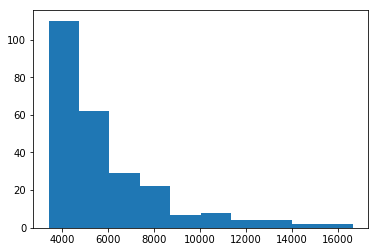

In [16]:
plt.hist(page_numbers)
plt.show()
#

#revs = pickle.load(open('Beer_Reviews_top5.pkl'))
revs = defaultdict()
k = 5
per = 0
for n in range(len(LT))[3014:9874]:
    #print LT[n]
    old_per = per
    per = ((float(n)-3014)/6859)*100
    if int(per)>int(old_per):
        print '{}\r'.format(per)
    req = urllib2.Request(LT[n], headers={'User-Agent' : "Magic Browser"}) 
    com = urllib2.urlopen( req )
    sand = BeautifulSoup(com,'lxml')
    rev = sand.find_all(id = 'rating_fullview_content_2')
    reviews = []
    for beers in range(len(rev)):
        words = [x for x in rev[beers].children]
        text = ''.join(x for x in words if type(x) == bs4.NavigableString and not x.startswith(u'\xa0'))
        if text != '':
            reviews.append(text)
    if LT[n][-2:] == '=0':
        revs[names_final[k]] = reviews
        k = k+1
    else:
        revs[names_final[k-1]].append(reviews)
        
        

pickle.dump(revs,open( "Beer_Reviews_6-20.pkl", "wb" ) )

In [17]:
#revs['Dreadnaught IPA']

#revs = pickle.load(open('Beer_Reviews_top5.pkl'))
revs = defaultdict()
k = 0
per = 0
for n in range(len(LT)):
    #print LT[n]
    old_per = per
    per = (((float(n)))/58000)*100
    if int(per)>int(old_per):
        print '{}\r'.format(per)
    req = urllib2.Request(LT[n], headers={'User-Agent' : "Magic Browser"}) 
    com = urllib2.urlopen( req )
    sand = BeautifulSoup(com,'lxml')
    rev = sand.find_all(id = 'rating_fullview_content_2')
    reviews = []
    for beers in range(len(rev)):
        words = [x for x in rev[beers].children]
        text = ''.join(x for x in words if type(x) == bs4.NavigableString and not x.startswith(u'\xa0'))
        if text != '':
            reviews.append(text)
    if LT[n][-2:] == '=0':
        revs[names_final[k]] = reviews
        k = k+1
    else:
        revs[names_final[k-1]].append(reviews)
        

In [18]:
#pickle.dump(revs,open( "Beer_Reviews.pkl", "wb" ) )

In [19]:
req = urllib2.Request(final_url[84], headers={'User-Agent' : "Magic Browser"}) 
com = urllib2.urlopen( req )
thing = BeautifulSoup(com,'lxml')
place = thing.find_all(id = 'rating_fullview_content_2')[5]
new = place.find(class_='username')
cool = new.find_next()
cool.contents

[u'Oct 22, 2017']

In [20]:
stuff = thing.find_all(class_='username')[1::2]
[x.find_next().contents for x in stuff]

[[u'Today at 08:20 PM'],
 [u'Sunday at 04:01 PM'],
 [u'Oct 28, 2017'],
 [u'Oct 28, 2017'],
 [u'Oct 25, 2017'],
 [u'Oct 22, 2017'],
 [u'Oct 21, 2017'],
 [u'Oct 18, 2017'],
 [u'Oct 18, 2017'],
 [u'Oct 17, 2017'],
 [u'Oct 15, 2017'],
 [u'Oct 13, 2017'],
 [u'Oct 13, 2017'],
 [u'Oct 12, 2017'],
 [u'Oct 07, 2017'],
 [u'Oct 03, 2017'],
 [u'Oct 02, 2017'],
 [u'Sep 27, 2017'],
 [u'Sep 27, 2017'],
 [u'Sep 24, 2017'],
 [u'Sep 19, 2017'],
 [u'Sep 19, 2017'],
 [u'Sep 18, 2017'],
 [u'Sep 14, 2017'],
 [u'Sep 13, 2017']]

In [ ]:
stuff = thing.find_all(class_='BAscore_norm')
[x.contents for x in stuff]
names_final

[u'Founders Breakfast Stout',
 u'90 Minute IPA',
 u'Pliny The Elder',
 u'Two Hearted Ale',
 u'Sculpin IPA',
 u'Heady Topper',
 u'Hopslam Ale',
 u'Founders KBS (Kentucky Breakfast Stout)',
 u'Old Rasputin Russian Imperial Stout',
 u'Bourbon County Brand Stout',
 u'60 Minute IPA',
 u'Sierra Nevada Pale Ale',
 u'Stone IPA (India Pale Ale)',
 u'Sierra Nevada Torpedo Extra IPA',
 u'Stone Enjoy By IPA',
 u'Arrogant Bastard Ale',
 u'Lagunitas Sucks (Brown Shugga Substitute Ale)',
 u'Sierra Nevada Celebration Ale',
 u'Zombie Dust',
 u'La Fin Du Monde',
 u'Ten FIDY',
 u'St. Bernardus Abt 12',
 u'Trappistes Rochefort 10',
 u'Samuel Adams Boston Lager',
 u"A Little Sumpin' Sumpin' Ale",
 u'Lagunitas IPA',
 u'Fat Tire Amber Ale',
 u'Tr\xf6egs Nugget Nectar',
 u'Weihenstephaner Hefeweissbier',
 u'Founders Centennial IPA',
 u'Stone Imperial Russian Stout',
 u'120 Minute IPA',
 u'Founders Backwoods Bastard',
 u'Duvel Belgian Golden Ale',
 u'West Coast IPA',
 u'Founders Imperial Stout',
 u'Jai Alai IP

In [ ]:
dates = defaultdict()
#ratings = defaultdict()
k = 0
per = 0
for n in range(len(LT)):
    old_per = per
    per = (((float(n)))/58000)*100
    if int(per)>int(old_per):
        print '{}\r'.format(per)
    req = urllib2.Request(LT[n], headers={'User-Agent' : "Magic Browser"}) 
    com = urllib2.urlopen( req )
    sand = BeautifulSoup(com,'lxml')
    date = sand.find_all(class_='username')[1::2]
    date = [x.find_next().contents for x in date]
    #rat = sand.find_all(class_='BAscore_norm')
    #rat = [x.contents for x in rat]
    if LT[n][-2:] == '=0':
        dates[names_final[k]] = date
        #ratings[names_final[k]] = rat
        k = k+1
    else:
        dates[names_final[k-1]].append(date)
        #ratings[names_final[k-1]].append(rat)

1.0
2.0


In [ ]:
#This version with a for loop instead of a list comprehension does not cause memory problems like the list comprehension.
#Ask Ryan why this version runs so much smoother.
dates = defaultdict()
#ratings = defaultdict()
k = 0
per = 0
for n in range(len(LT)):
    old_per = per
    per = (((float(n)))/58000)*100
    if int(per)>int(old_per):
        print '{}\r'.format(per)
    req = urllib2.Request(LT[n], headers={'User-Agent' : "Magic Browser"}) 
    com = urllib2.urlopen( req )
    sand = BeautifulSoup(com,'lxml')
    date_obj = sand.find_all(class_='username')[1::2]
    for x in date_obj:
        date = x.find_next().contents
        #rat = sand.find_all(class_='BAscore_norm')
        #rat = [x.contents for x in rat]
        if LT[n][-2:] == '=0':
            dates[names_final[k]] = date
            #ratings[names_final[k]] = rat
            k = k+1
        else:
            dates[names_final[k-1]].append(date)

In [ ]:
pickle.dump(dates,open( "Beer_Dates.pkl", "wb" ) )
#pickle.dump(ratings,open( "Beer_Ratings.pkl", "wb" ) )

In [ ]:
req = urllib2.Request(final_url[84], headers={'User-Agent' : "Magic Browser"}) 
com = urllib2.urlopen( req )
thing = BeautifulSoup(com,'lxml')
stuff = thing.find_all(id = 'rating_fullview_content_2')
words = [x for x in stuff[1].children]
text = ''.join([x for x in words if type(x) == bs4.NavigableString and not x.startswith(u'\xa0')])
text

In [ ]:
req = urllib2.Request(final_url[84], headers={'User-Agent' : "Magic Browser"}) 
com = urllib2.urlopen( req )
thing = BeautifulSoup(com,'lxml')
stuff = thing.find(class_='ba-ratings')
numb = str(stuff.contents[0].strip(','))
numb = int(numb.replace(',',''))
numb

In [ ]:
text = ''.join(x for x in soup if type(x) == bs4.NavigableString and not x.startswith(u'\xa0'))